# "Should this loan be approved or denied?": A Classification Case Study

## I. Problem Statement

You have recently joined Fidelity Investments as an Analytics intern and the senior data scientist decides to test your ability to apply the skills you have learned! He throws some loan data at you and asks you to determine whether each person will have their loan approved depending on the risk of them defaulting.

## II. Questions to ask ourselves

1. Why is this a classification problem? What are we classifying?
2. What are the dependent and independent variables?
3. Is this a binary or multi-class classification problem?
3. What are some classifiication algorithms we can apply to solve this problem?

### Perform the necessary imports

**Note: If you don't have some of the packages installed, here is a list of commands you can run to install them:**

1. numpy: `conda install numpy`
2. pandas: `conda install pandas`
3. scikit-learn: `conda install scikit-learn`
4. matplotlib: `conda install matplotlib`
5. seaborn: `conda install seaborn`

In [1]:
%matplotlib inline
import numpy as np
np.seterr(divide='ignore')
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

### Read the data in using Pandas

Save the data in the CSV file provided into a variable named 'data'.

In [2]:
data = pd.<INSERT COMMAND HERE>('credit_risk.csv')

## III. Let's visualize!

Before we begin training our model, it is useful to see how the features are distributed as it would help us understand which features are correlated and would also help us isolate any red flags with the data.

### Let us begin with a general bar plot of the loan approval statuses

This will help us determine whether a class is underrepresented. Interpret the bar plot below. 

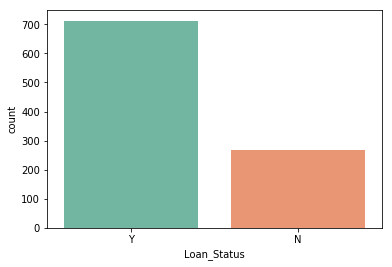

In [3]:
sns.countplot(x='Loan_Status', data=data, palette="Set2")

### Onto the distributions!

Let us see how the variables we picked are distributed to make sure that we have covered all bases when we preprocessed the data.

We will look at the distributions for following three variables:

1. Applicant income
2. Coapplicant income
3. Loan Amount
4. Credit history

Additionally, we will also look at

1. A count plot to see how many of the applicants are graduates.
2. A count plot to see how many of the applicants are self employed.
3. A scatter plot of the range of loans that were approved or denied.

/Users/vidhur2k/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


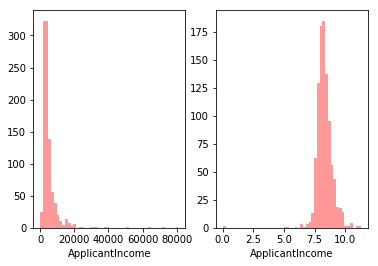

In [4]:
fig, ax =plt.subplots(1,2)

# Standard plot
sns.distplot(data['ApplicantIncome'], kde=False, color='r', ax=ax[0])

# Log plot
applicantIncomeCol = np.log(data['ApplicantIncome'])
applicantIncomeCol = applicantIncomeCol.replace([np.inf, -np.inf], 0)

sns.distplot(applicantIncomeCol, kde=False, color='r', ax=ax[1])

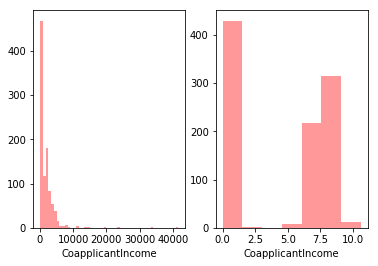

In [5]:
fig, ax =plt.subplots(1,2)

# Standard plot
sns.distplot(data['CoapplicantIncome'], kde=False, color='r', ax=ax[0])

# Log plot
coapplicantIncomeCol = np.log(data['CoapplicantIncome'])
coapplicantIncomeCol = coapplicantIncomeCol.replace([np.inf, -np.inf], 0)

sns.distplot(coapplicantIncomeCol, kde=False, color='r', ax=ax[1])

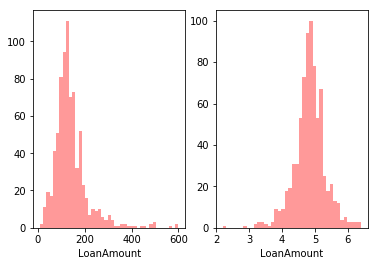

In [6]:
fig, ax =plt.subplots(1,2)

# Standard plot
sns.distplot(data.dropna()['LoanAmount'], kde=False, color='r', ax=ax[0])

# Log plot
loanAmountCol = np.log(data.dropna()['LoanAmount'])
loanAmountCol = loanAmountCol.replace([np.inf, -np.inf], 0)

sns.distplot(loanAmountCol, kde=False, color='r', ax=ax[1])

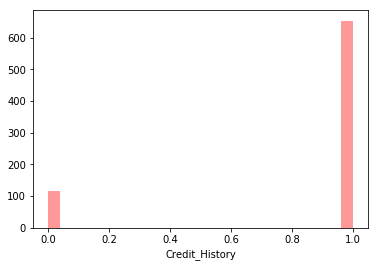

In [7]:
sns.distplot(data.dropna()['Credit_History'], kde=False, color='r')

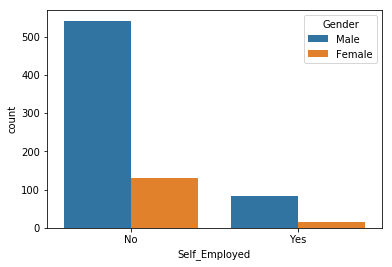

In [8]:
sns.countplot(x="Self_Employed", hue="Gender", data=data.dropna())

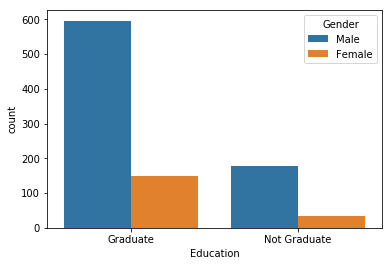

In [9]:
sns.countplot(x="Education", hue="Gender", data=data)

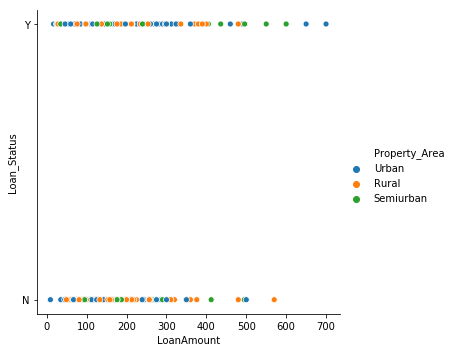

In [10]:
sns.relplot(x="LoanAmount", y="Loan_Status", hue="Property_Area", data=data)

## IV. Preprocessing our data

Before we begin using our data to train the model, it is necessary for us to perform some preliminary data exploration and cleaning to make sure that the dataset we have is usable.

### Let us check for missing values

It is important for us to understand how many values in each column are missing and whether or not removing/replacing them changes the distribution of the data in any particular way.

In [11]:
data.isnull().sum(axis = 0) / data.shape[0] * 100 

Loan_ID              0.000000
Gender               2.446483
Married              0.305810
Dependents           2.548420
Education            0.000000
Self_Employed        5.606524
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           2.752294
Loan_Amount_Term     2.038736
Credit_History       8.053007
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

### Removing unncessary columns

In our case, the Loan ID is unnecessary when determining whether or not the loan will be approved. Therefore, we do not need it.

In [12]:
data.drop(['Loan_ID'], axis = 1, inplace=True)

# Drop null and NAN values from the data.
data.dropna(inplace=True)

# This is our target vector
y = data.Loan_Status

# We will drop the target column from our dataframe as it is not a feature.
data.drop(['Loan_Status'], axis = 1, inplace=True)

### Let us visualize the Correlation matrix

We can use seaborn's heatmap to visualize the correlation matrix for our dataset. This will help us check the relative independence between the variables. The entry at (i, j) is the correlation coefficient between the variables at row 'i' and column 'j' respectively.

Do you see any pairs of variables with a significant correlation?

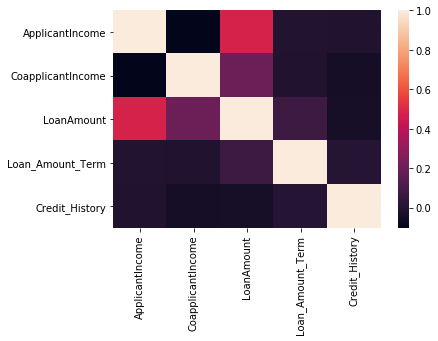

In [13]:
sns.heatmap(data.corr())

### Cateogorical Label Encoding

Categorical encoding is a necessary step in data preprocessing. While using any of the classification methods that we learnt, it becomes necessary for us to map any categorical values to numeric values in order to train the model on those values. In our case, we will use one hot encoding to encode the categorical variables.

#### Which variables are categorical in our dataset?

In [14]:
# Replace the categorical values with the numeric equivalents that we have above
categoricalFeatures = ['Property_Area', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed']

# Iterate through the list of categorical features and one hot encode them.
for feature in categoricalFeatures:
    onehot = pd.get_dummies(data[feature], prefix=feature)
    data = data.drop(feature, axis=1)
    data = data.join(onehot)

## V. Training the model

As discussed before, we'll use logistic regression to classify the data points. This is an apt choice because we have two classes (binary classifcation) and the output is discrete.

In [15]:
# Liblinear is a solver that is effective for relatively smaller datasets.
lr = LogisticRegression(solver='liblinear')

In [21]:
# We will follow an 80-20 split pattern for our training and test data
X_train,X_test,y_train,y_test = train_test_split(data, y, test_size=0.2, random_state = 0)

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## VI. Evaluating the performance using the metrics we learned

Recall that we went over a few methods to check how well our model is performing. The confusion matrix helps us determine where the model is getting 'confused'. Using the heatmap visualization feature provided by seaborn, we can plot the confusion matrix.

First, let us recall the following metrics:

1. Accuracy
2. Precision
3. Recall

In [23]:
# We will compare this vector of predictions to the actual target vector to determine the model performance.
y_pred = lr.predict(X_test)

# Build the confusion matrix.
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

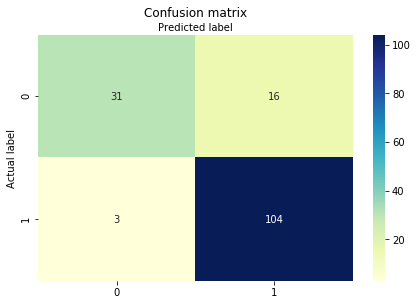

In [24]:
class_names=[0,1] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# The heatmap requires that we pass in a dataframe as the argument
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu", fmt="g")

# Configure the heatmap parameters
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
# Print out our performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label='Y'))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label='Y'))

Accuracy: 0.8766233766233766
Precision: 0.8666666666666667
Recall: 0.9719626168224299


## Resources and Additional Readings

Seaborn: https://seaborn.pydata.org/tutorial.html  
Understanding Logistic Regression: https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102  
Newton Conjugate Gradient Optimization: https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method  
The Data Science Pipeline: https://towardsdatascience.com/a-beginners-guide-to-the-data-science-pipeline-a4904b2d8ad3  
Support Vector Machines vs Logistic Regression: https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f  
Does balancing classes improve classifier performance: http://www.win-vector.com/blog/2015/02/does-balancing-classes-improve-classifier-performance/